<a href="https://colab.research.google.com/github/MelMacLondon/ML/blob/main/TransferLearning_SqueezeNet_GPU_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Practical: Working with Pretrained Models
This practical introduces transfer learning with SqueezeNet, a lightweight convolutional neural network architecture designed to achieve AlexNet-level accuracy on ImageNet with 50× fewer parameters. SqueezeNet was trained on the large-scale ImageNet dataset, which contains over a million labeled images across 1,000 classes. By reusing these pretrained weights, we avoid the need to train a deep network from scratch – a process that would otherwise require extensive data, long training times, and significant computational resources.

The key advantage of using a pretrained model is that its early convolutional layers have already learned general visual features such as edges, textures, and simple shapes. These representations transfer well to new tasks, even when the target dataset is much smaller. This reduces training time, improves generalisation, and makes it feasible to achieve strong results with limited resources.

In this exercise, we will adapt SqueezeNet to the CIFAR dataset by loading the pretrained backbone, modifying the classifier head, and then training this head to establish a strong feature-extraction baseline. We will then fine-tune the model by unfreezing selected backbone layers and optimising with retraining.




First, let's import the required packages

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from tqdm import tqdm

Although CIFAR10 is small compared to other datasets, it is still time consuming to train a model on the entire dataset. As such, we will only be using a subset of the data to train our model, similar to what we did in the previous practical. Run the code below to define the function we will use to created a balanced subset of the dataset. For our fine-tuning, we will be using 500 samples per class.

In [28]:
def create_balanced_subset(dataset, samples_per_class=500):
    """Create a subset with equal number of samples per class"""
    targets = np.array(dataset.targets)
    indices = []

    for class_idx in range(10):                            # CIFAR10 has 10 classes
        class_indices = np.where(targets == class_idx)[0]
        selected = np.random.choice(class_indices, samples_per_class, replace=False)
        indices.extend(selected)

    return Subset(dataset, indices)

**Q1)** When using a pretrained model, the input data must be normalised with the same statistics as the data on which the model was originally trained. Create a transform called `transform` that performs the following steps:

1. Convert images to tensors.

2. Normalise each channel using the parameters:

* Mean = (0.485, 0.456, 0.406)

* Standard deviation = (0.229, 0.224, 0.225)


In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

Run the cell below that uses the transform to create the training and test datasets and dataloaders.

In [30]:
# Download the data
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Create balanced subsets
train_subset = create_balanced_subset(train_dataset, samples_per_class=500)  # 5000 total
test_subset = create_balanced_subset(test_dataset, samples_per_class=100)    # 1000 total

# Class names for CIFAR10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=256, shuffle=False)

**Q2)** Load and create an instance of SqueezeNet and assign it to a variable called `squeezenet`. When loading a pretrained model, we need to set the argument `weights` to the dataset that the network was pretrained on. For this our model, we will use `IMAGENET1K_V1`.

The syntax for loading a pretrained model is as follows:

```python
model_instance = models.pretrained_model_name(parameters)
```

Print the model to examine its architecture.

In [31]:
squeezenet = models.squeezenet1_1(weights="IMAGENET1K_V1")
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

SqueezeNet is organised into two main parts:

* Features – the convolutional backbone that extracts features.

* Classifier – the final layers that map features to class scores (1000 for ImageNet).

The flow of data through the network is as follows:

Input → features (series of conv, ReLU, pooling, Fire modules) → classifier (dropout, 1×1 conv, ReLU, global avg pool) → logits.

Note: Fire modules are the building blocks of SqueezeNet. Each Fire block has:

* Squeeze layer: a 1×1 convolution that reduces the number of channels ("squeezes" the representation).
* Expand layers: two parallel convs – one 1×1 and one 3×3 (with padding=1 so the output size matches).
* The outputs of expand1×1 and expand3×3 are concatenated along the channel dimension.
example:

- Input: 3 channels
- Squeeze: 16 channels
- Expand1x1: 64 channels
- Expand3x3: 64 channels
- Output: 128 channels





**Q3)** The images in the CIFAR-10 dataset are 32×32 pixels, whereas the images used to train ImageNet models are 224×224 pixels. To apply a pretrained model such as SqueezeNet, we have two options:

1. Resize the CIFAR-10 images to 224×224.
2. Modify the pretrained model so that it can operate directly on 32×32 inputs.

Resizing is straightforward but computationally more expensive and may blur small images, making training harder. A more efficient approach is to adjust the architecture of SqueezeNet so that it preserves more spatial detail when working with 32×32 inputs.

In the cell below, modify squeeznet's architecture in the following ways:

- Change the **stride** of the first convolutional layer to 1 (layer index 0).
- Change the **padding** of the first convolutional layer to 1 (level 0)
- Remove the first max-pool layer (layer index 2) by replacing it with `nn.Identity()`

The syntax for modifying the network is as follows:

```python
# change an attribute
model.features[level].attribute = new_value  

# replace an entire layer
model.features[level] = nn.NewLayerType(args)
```


In [32]:

squeezenet.features[0].stride = (1, 1)
squeezenet.features[0].padding = (1, 1)
squeezenet.features[2] = nn.Identity()


**Q4)** The original SqueezeNet model was trained on ImageNet, which has 1,000 output classes. Since CIFAR-10 has only 10 classes, we need to replace the final classifier layer so that the network outputs 10 logits instead of 1,000.

In the cell below, modify the classifier with a new layer that maps from `in_channels = 512` to `out_channels = 10`. Also update the `num_classes` attribute of the model.

```python
# replace an entire layer
model.features[level] = nn.NewLayerType(args)
```

In [33]:
label_size = 10

squeezenet.classifier[1] = nn.Conv2d(
        in_channels=512,
        out_channels=label_size,
        kernel_size=1,
        bias=True)

squeezenet.num_classes = label_size


For the purposes of this practical, we will freeze the backbone of the SqueezeNet model and only train the head. Freezing the backbone reduces backprop computation because gradients aren’t calculated for those layers and is standard practice when using transfer learning.

In [34]:
# Freeze backbone
for p in squeezenet.features.parameters():
    p.requires_grad = False

**Q5)** In the current setup all layers of the SqueezeNet model are frozen, meaning no parameters will be updated during training. To allow learning, we need to unfreeze the classifier layer so that its parameters can be optimised. In the cell below, unfreeze the classifier layer (located in classifier at index 1) using code similar to that in the previous cell.

In [35]:

for p in squeezenet.classifier[1].parameters():
    p.requires_grad = True


We are now ready to train the model. In the cell below, we will define the loss function and optimizer, and then train the model for a few epochs. We will only train the new head of the model, as the rest of the model is frozen. We will also use a smaller learning rate and a smaller weight decay (L2 regularisation).

* A smaller learning rate helps prevent large updates that could destabilise training when starting from pretrained weights, ensuring that the network adapts gradually rather than overwriting useful representations.

* A smaller weight decay avoids overly strong regularisation on pretrained parameters, which could otherwise push them away from the values learned on ImageNet that already encode useful general features.

In [36]:

# check for GPU and run on the GPU if available using device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeezenet.to(device)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Identity()
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1

In [37]:
# check what device we have

device

device(type='cuda')

In [38]:
# Loss + optimizer (only trainable params)
criterion = nn.CrossEntropyLoss().to(device)

# Train only the new head with AdamW
optimizer = torch.optim.AdamW(
    squeezenet.classifier[1].parameters(),  # just the head
    lr=1e-3,
    weight_decay=1e-4
)

num_epochs = 10   #  original code says 3 - this is running now on GPU (CUDA) so tried 10!!

train_losses, train_accuracies = [], []

squeezenet.train().to(device)


for epoch in range(num_epochs):   # one epoch only

    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):

        # Move images and labels to the device (GPU if available)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = squeezenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

Epoch 1: 100%|██████████| 40/40 [00:02<00:00, 18.60it/s]


Epoch 1: loss=1.7059, acc=0.4136


Epoch 2: 100%|██████████| 40/40 [00:01<00:00, 23.55it/s]


Epoch 2: loss=1.1150, acc=0.6150


Epoch 3: 100%|██████████| 40/40 [00:01<00:00, 22.51it/s]


Epoch 3: loss=0.9455, acc=0.6702


Epoch 4: 100%|██████████| 40/40 [00:01<00:00, 23.04it/s]


Epoch 4: loss=0.8505, acc=0.7054


Epoch 5: 100%|██████████| 40/40 [00:02<00:00, 19.97it/s]


Epoch 5: loss=0.8167, acc=0.7154


Epoch 6: 100%|██████████| 40/40 [00:01<00:00, 20.23it/s]


Epoch 6: loss=0.7799, acc=0.7248


Epoch 7: 100%|██████████| 40/40 [00:01<00:00, 21.93it/s]


Epoch 7: loss=0.7415, acc=0.7422


Epoch 8: 100%|██████████| 40/40 [00:01<00:00, 23.07it/s]


Epoch 8: loss=0.7214, acc=0.7432


Epoch 9: 100%|██████████| 40/40 [00:01<00:00, 23.55it/s]


Epoch 9: loss=0.6919, acc=0.7544


Epoch 10: 100%|██████████| 40/40 [00:01<00:00, 23.53it/s]

Epoch 10: loss=0.6775, acc=0.7678


After only 3 epochs are model is doing better than our previous model. Lets see take a look at the training curves.

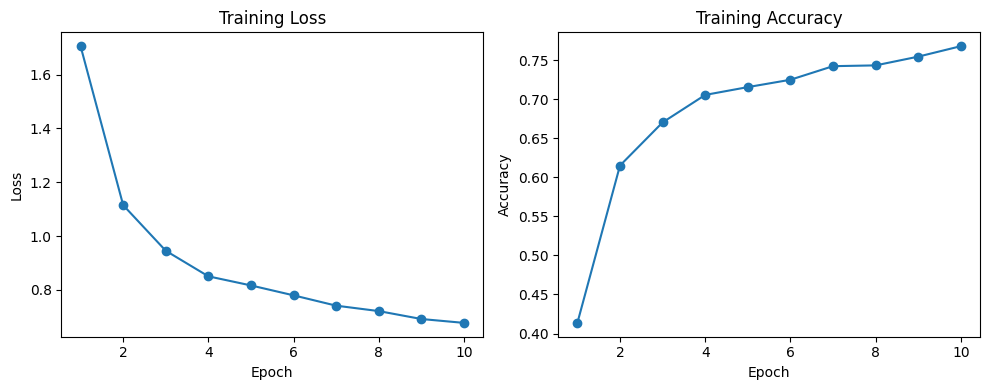

In [39]:
# Plot training loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training Accuracy')
plt.tight_layout()
plt.show()

Although we only trained for 3 epochs, we can see that the model is already learning and the accuracy is increasing. Run the code below to evaluate the model on the test set.

In [40]:
squeezenet.eval().to(device)
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet(images)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Test accuracy: {correct / total:.4f}')

Test accuracy: 0.7220


Not bad for a model that was trained for only 3 epochs! Finally, take a look at the confusion matrix to see how the model is performing on each class.

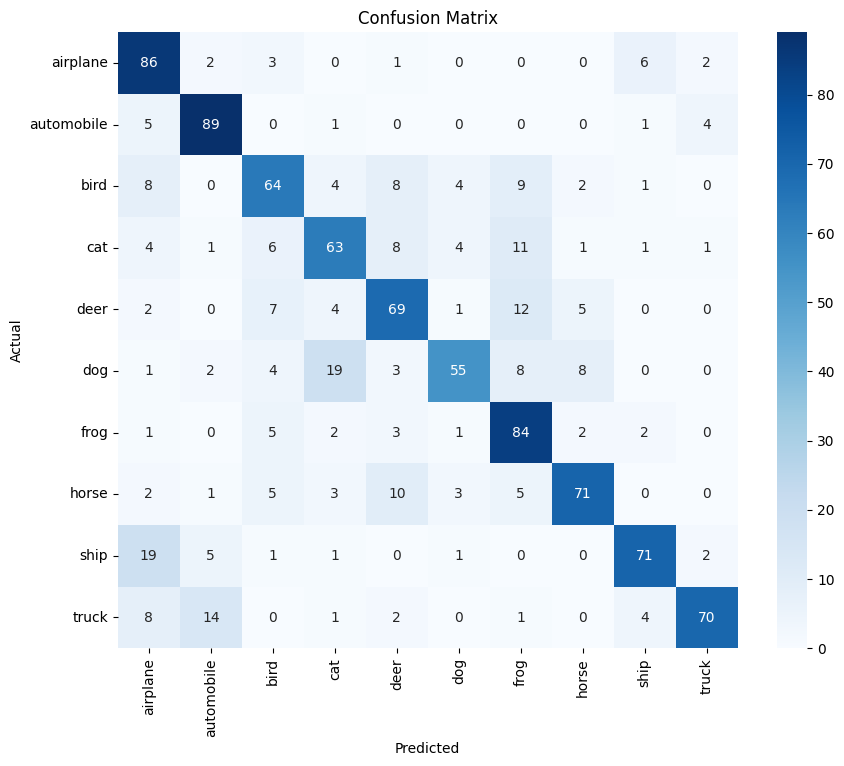

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Do you notice anything about the confusion matrix that could explain why the model is performing well on some classes and not others?